### Data preprocessing

In [27]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization
from tqdm import tqdm #tracking the function execution process
import re
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Stop-words are the most common words in a language that are to be filtered out before processing
nltk.download('stopwords')

In [ ]:
news_data = pd.read_csv('news.csv', index_col=0)
news_data.shape

In [30]:
# view of the first three entries
news_data.head(3)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0


In [31]:
# the title, subject, and date columns will not be used to classify news
news_data = news_data.drop(['title', 'subject', 'date'], axis=1)

In [32]:
# shuffling - method that randomly shuffles data records without changing their contents
# without shuffling, the model can assimilate patterns based on the order of the data
news_data = news_data.sample(frac=1)

In [33]:
# resetting the index
news_data.reset_index(drop=True, inplace=True)

In [104]:
# removes duplicates based on the "text" column while preserving the last occurrence
news_data.drop_duplicates(subset=['text'], keep='last')
news_data.shape

(44919, 2)

In [105]:
#checking the number of missing values in the data
news_data.isnull().sum()

text     0
class    0
dtype: int64

In [106]:
news_data.head(3)

,text,class
0,washington reuter member us hous repres intell...,1
1,seoul reuter north korea said us b1b bomber fl...,1
2,muhoroni kenya reuter kenya repeat presidenti ...,1


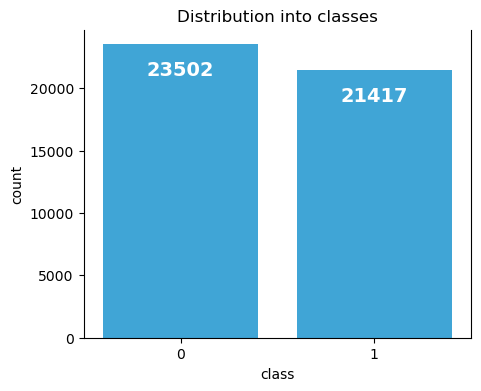

In [37]:
# graph to determine if there is a class imbalance
countplt, ax = plt.subplots(figsize = (5, 4))
distrib_count = sns.countplot(data = news_data, x ='class', order=news_data['class'].value_counts().index, color='#27aeef')
ax.spines['top'].set_visible(False)
ax.bar_label(distrib_count.containers[0], padding=-25, color='white', 
             fontsize=14, label_type='edge', fontweight='bold')
plt.title("Distribution into classes")
plt.show()

### Function for data processing

**Stemming** is the process of reducing the word to its word stem that affixes to suffixes and prefixes or to roots of words known as a lemma.

Example: singing ----> sing

In [38]:
# create a Porter Stemmer instance
stemmer = PorterStemmer()

In [39]:
def preprocess_text(data_text):
    preprocessed_text = []
    
    for sentence in tqdm(data_text):
        # remove all non-alphabetic characters and replace them with spaces
        sentence = re.sub(r'[^\w\s]', '', sentence)
        # сonvert the text to lowercase
        sentence = sentence.lower()
        # split the text
        sentence = sentence.split()
        # apply stemming to each word and removing stopwords
        # join the words back into a single string
        preprocessed_text.append(' '.join(stemmer.stem(symbol)
                                  for symbol in sentence
                                  if symbol not in stopwords.words('english')))

    return preprocessed_text

In [40]:
# data processing using the created function
processed_data = preprocess_text(news_data['text'].values)
news_data['text'] = processed_data

100%|██████████████████████████████████████████████████████████████████████████| 44919/44919 [8:24:56<00:00,  1.48it/s]


### Word Cloud ###

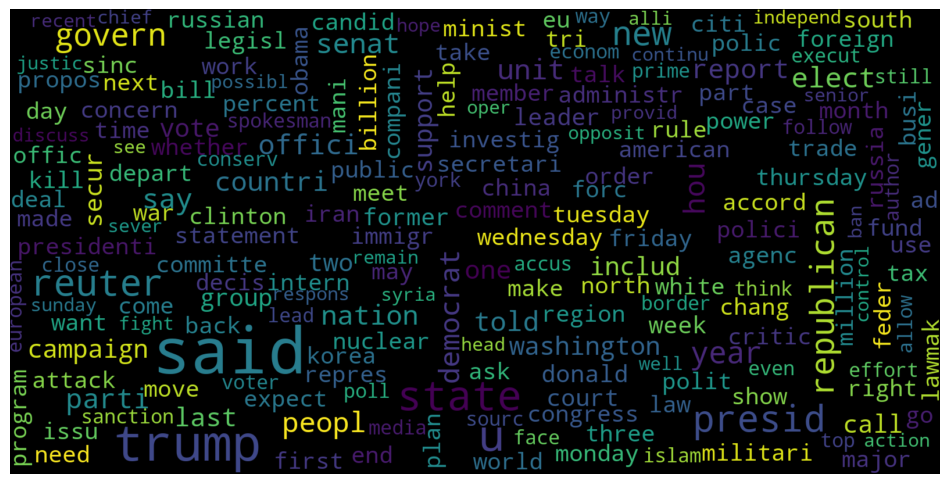

In [93]:
# Real
consolidated = ' '.join(
    word for word in news_data['text'][news_data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(12, 8))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

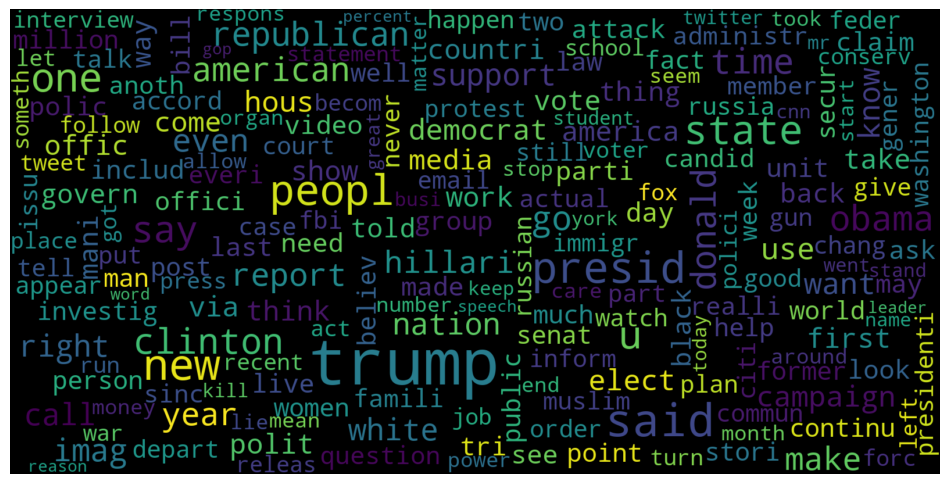

In [94]:
# Fake
consolidated = ' '.join(
    word for word in news_data['text'][news_data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(12, 8))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

### Сonverting the training data into vectors

In [43]:
# Split into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(news_data['text'], 
                                                      news_data['class'], 
                                                      test_size=0.25,
                                                      random_state=42)

In [44]:
# Initializing a TF-IDF vectorizer object
tfidf_vectorizer=TfidfVectorizer()

# Transforming the raw text data from the training set into TF-IDF features and storing it in the variable X_train
X_train=tfidf_vectorizer.fit_transform(X_train)

# Transforming the raw text data from the testing set into TF-IDF features and storing it in the variable X_test
X_test=tfidf_vectorizer.transform(X_test)

### Logistic Regression

In [ ]:
# initialization and training of the Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

In [108]:
# testing the model with accuracy score
accuracy_score_lr = round(accuracy_score(y_test, lr.predict(X_test)) * 100, 2)
print(f'Accuracy score of the test data : {accuracy_score_lr}%')

Accuracy score of the test data : 98.5%


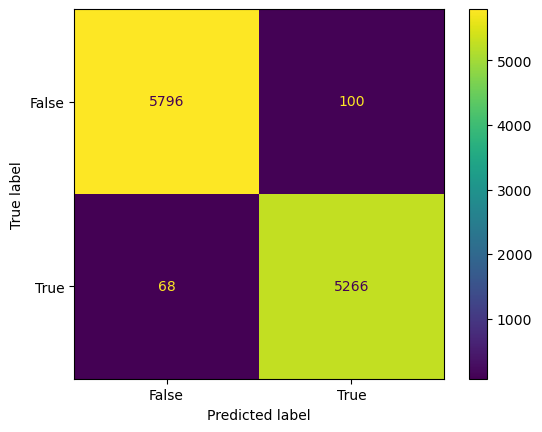

In [95]:
# confusion matrix of results from logistic Regression
cm = metrics.confusion_matrix(y_test, lr.predict(X_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()

### Passive Aggressive Classifier

In [123]:
# initialization and training of the Passive Aggressive Classifier
pac = PassiveAggressiveClassifier()
pac.fit(X_train,y_train)

PassiveAggressiveClassifier()

In [124]:
# testing the model with accuracy score
accuracy_score_pac = round(accuracy_score(y_test, pac.predict(X_test)) * 100, 2)
print(f'Accuracy score of the test data : {accuracy_score_pac}%')

Accuracy score of the test data : 99.42%


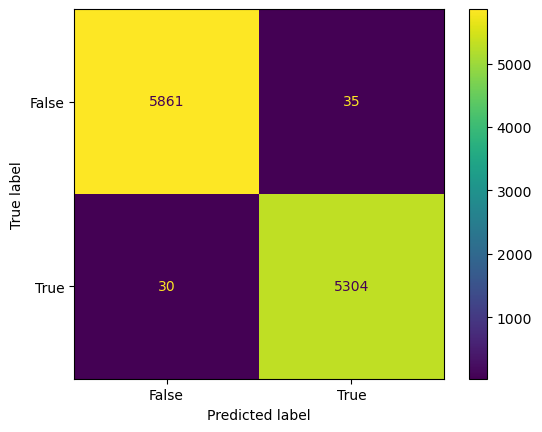

In [125]:
# confusion matrix of results from Passive Aggressive Classifier
cm = metrics.confusion_matrix(y_test, pac.predict(X_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()

### Support Vector Machines

In [51]:
# initialization and training of the SVM
svm = svm.SVC()
svm.fit(X_train, y_train)

SVC()

In [100]:
# testing the model with accuracy score
accuracy_score_svm = round(accuracy_score(y_test, svm.predict(X_test)) * 100, 2)
print(f'Accuracy score of the test data : {accuracy_score_svm}%')

Accuracy score of the test data : 99.19%


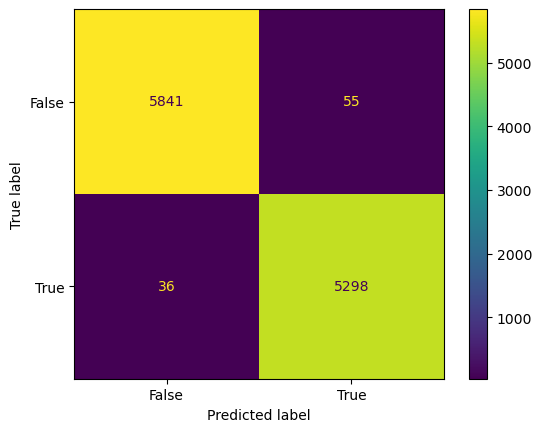

In [102]:
# confusion matrix of results from Support Vector Machines
cm = metrics.confusion_matrix(y_test, svm.predict(X_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()

### Naive Bayes Classifier

In [54]:
# initialization and training of the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [85]:
# testing the model with accuracy score
accuracy_score_nb = round(accuracy_score(y_test, nb_classifier.predict(X_test)) * 100, 2)
print(f'Accuracy score of the test data : {accuracy_score_nb}%')

Accuracy score of the test data : 93.79%


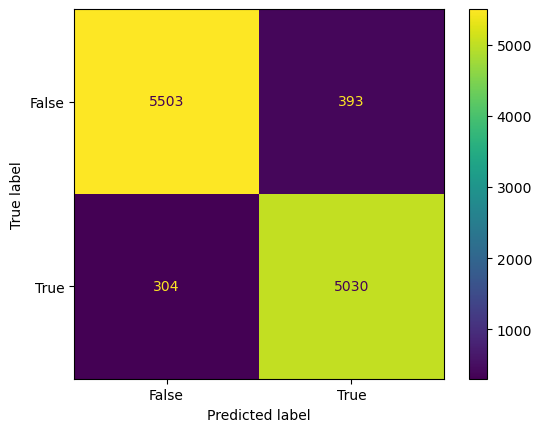

In [56]:
# Confusion matrix of results from Naive Bayes classifier
cm = metrics.confusion_matrix(y_test, nb_classifier.predict(X_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()

### Decision Tree Classifier

In [167]:
# initialization and training of the Decision Tree classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [168]:
# testing the model with accuracy score
accuracy_score_dt = round(accuracy_score(y_test, dt_clf.predict(X_test)) * 100, 2)
print(f'Accuracy score of the test data : {accuracy_score_dt}%')

Accuracy score of the test data : 99.7%


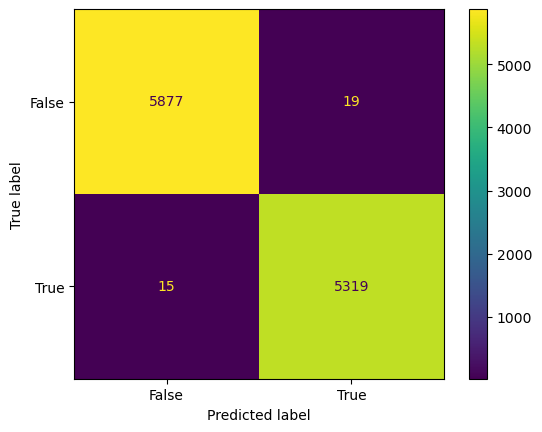

In [170]:
# confusion matrix of results from Decision Tree classifier
cm = metrics.confusion_matrix(y_test, dt_clf.predict(X_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()

### Accuracy of different ML models

In [171]:
results = pd.DataFrame({'names' : ["Naive Bayes", "PAC", "Decision Tree", "SVM", "Logistic Regression"],
                        'accuracy' : [accuracy_score_nb, accuracy_score_pac, accuracy_score_dt, accuracy_score_svm, accuracy_score_lr]})

In [172]:
colors = ['#007F99', '#007F99', '#007F99', '#007F99', '#F99B0C']
results = results.sort_values(by='accuracy')

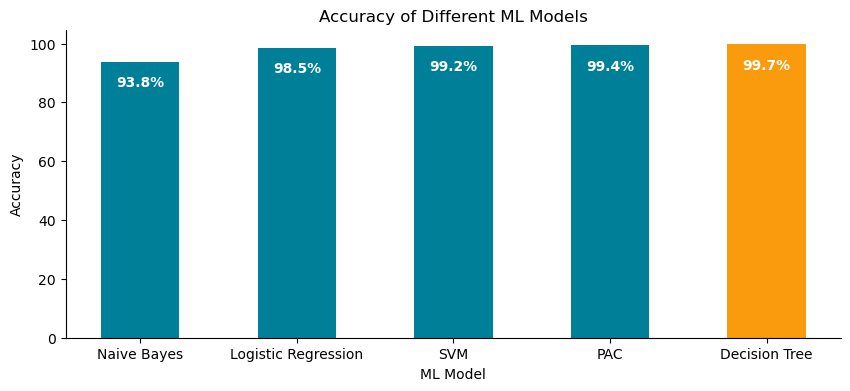

In [176]:
# Plot a bar graph
fig, ax = plt.subplots(figsize=(10, 4))
bars = plt.bar(results['names'], results['accuracy'], color = colors, width=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.bar_label(bars, padding=-20, color='white', 
             fontsize=10, label_type='edge', fmt='%.1f%%',
             fontweight='bold')
plt.xlabel('ML Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different ML Models')
plt.show()

#### The decision tree classifier is the best classifier with an accuracy score of 99.7%